In [1]:
# Magic commands
%matplotlib inline

# External packages
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML
from datetime import datetime

# cQED modules
from plotsettings import *
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"

In [8]:
# Device 
Nq = 2         # number of levels in qubit
Nc = 10         # number of levels in resonator 1
wq = 6.5 *2*pi  # bare g-e qubit transition frequency
wc = 4.0 *2*pi  # bare resonator frequency
Ec = 0.2 *2*pi  # anharmonicity (charging energy)
g  = 0.2 *2*pi  # coupling between qubit and resonator

# Anharmonicity approximation
anh_appr = False  # remove off-diagonal elements from H_anh?

# Sideband transitions
sb = 'blue'  # type of sideband transitions
Nt = 1      # number of drive tones

# Single-tone
eps_list = np.linspace(0.8, 0.8, 1) *2*2*pi
wd_list  = np.linspace(5.8829, 5.8829, 1) *2*pi

# Double-tone
epsfac_list = np.linspace(0.0, 3.0, 2)  # factor with which to scale the drive tone amplitudes
wdq         = np.linspace(3.0, 5.0, 2)  # frequency of qubit-friendly drive tone
epsq_list   = epsfac_list * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
epsc_list   = epsfac_list * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
dw     = 0.5 *2*pi               # detuning of wdc from wc
wdc    = wc - dw                 # frequency of cavity-friendly drive tone

# Time cycle
t0 = 0         # start of simulation
t1 = t0 + 0    # start of drive and coupling
t2 = t1 + 50  # end of drive of drive and coupling
t3 = t2 + 0    # end of simulation

# Gaussian rise and fall
tg = 10         # length of gaussian rise and fall
gauss = True    # whether or not to rise and fall with gaussian
smooth = False  # whether to start gaussian at 0 or with small jump
Q = 3           # number of std's in gaussian rise and fall

# Convergent method
convergent = False  # use convergent method

# Integration
method = 'bdf'  # mesolve's integration method, either 'bdf' or 'adams'

In [9]:
b, a, nq, nc = ops(Nq, Nc)  # Operators

# Individual Hamiltonian terms
if anh_appr or Nq == 2:
    Hi = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b  # devices intrinsic
else:
    Hi = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4
Hc = g*(a + a.dag())*(b + b.dag())  # coupling

In [10]:
# Set the initial state based on the type of sideband transition
if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # Red: qubit excited, cavity in ground state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # Blue: both qubit and cavity in ground state

# Set the expectation and collapse operators for the solver
e_ops = [nq, nc]  # expectation operators
c_ops = []        # collapse operators

# Set the options for the Lindblad ME solver
options = Options()
options.store_states=True
if method == 'bdf':
    options.method = 'bdf'
    options.rtol = 1e-10
    options.atol = 1e-10
else:  # adams
    options.nsteps = 1000
    options.rtol = 1e-10
    options.atol = 1e-10
    options.max_step = 0

# Set the time steps for which to store the output of the solver
if not convergent:
    Np = 100 *int(t3)  # number of equidistant data points in time
    print("timestep =", 1e3*np.round(t3/Np, 5), "ps")
elif convergent:
    Np = 2 *int(t3)    # number of equidistant data points in time
    print("timestep =", 1e3*np.round((t3-2*tg)/Np, 5), "ps")
Np_per_batch = Np/int(np.round(t3/10))  # number of time points per batch

timestep = 10.0 ps


In [11]:
data = {
    'Nq' : Nq, 'Nc' : Nc, 'wq' : wq, 'wc' : wc, 'Ec' : Ec, 'g'  : g, 'anh_appr' : anh_appr, 'sb' : sb, 'Nt' : Nt,
    't0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'gauss' : gauss, 'smooth' : smooth, 'Q'  : Q,
    'convergent' : convergent, 'Np' : Np
}

In [18]:
def sbsample(Nq, wq, wc, Ec, g, wd, sb, Nt, H, H_args, psi0, Np_per_batch,
             options, home, parallel, *args):
    from envelopes import drive
    
    i = wd[0]
    wd = wd[1]
    
    Nc = 10  # number of levels in resonator 1
    
    Np = 100*int(H_args['t3'])  # number of discrete time steps for which to store the output
    b, a, nq, nc = ops(Nq, Nc)  # Operators
    if Nt == 1:
        H_args['wd'] = wd
    elif Nt == 2:
        dw = args[2]
        wdq = wd
        wdc =  wc - dw
        H_args['wdq'] = wdq
        H_args['wdc'] = wdc
    e_ops = [nq, nc]
    c_ops = []
        
    srcfolder = calculate(H, psi0, e_ops, c_ops, H_args, options, Nc, Np, Np_per_batch,
                          home, parallel, verbose=False)
    
    quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']
    ID = getID(srcfolder)
    combine_batches(srcfolder, quants=quants, return_data=False)
    times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)
    
    if i < 10:
        num = "0" + str(i)
    elif i >= 10:
        num = str(i)
        
    e1g0_macro, e1g0_macro_times = remove_micromotion((e1-g0)[1000:-1000], times[1000:-1000], method='savgol')
    e0g1_macro, e0g1_macro_times = remove_micromotion((e0-g1)[1000:-1000], times[1000:-1000], method='savgol')
    
    e1g0_macro, e1g0_macro_times = remove_micromotion((e1-g0), times, method='savgol')
    e0g1_macro, e0g1_macro_times = remove_micromotion((e0-g1), times, method='savgol')

    if sb == 'red':
        maximum = max(e0g1_macro)
        minimum = min(e0g1_macro)
        wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
    elif sb == 'blue':
        maximum = max(e1g0_macro)
        minimum = min(e1g0_macro)
        wsb = sideband_freq(e1g0_macro, e1g0_macro_times)
    
    plt.figure()
    plt.plot(times, e0-g1)
    plt.plot(e0g1_macro_times, e0g1_macro)
    plt.show()
    
    return wsb, minimum, maximum

1 / 1
         increase the simulation time


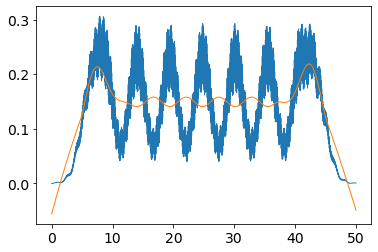

In [19]:
Npool = 2  # number of parallel simulations

if Nt == 1:
    maxima = np.zeros([len(eps_list), len(wd_list)])
    wsbs   = np.zeros([len(eps_list), len(wd_list)])
    
    for i, eps in enumerate(eps_list):
        print("{} / {}".format(i+1, len(eps_list)))
        Hd = eps*(b + b.dag())    # single-tone drive
        H = [Hi, [Hc, drive_nonosc], [Hd, drive]]  # monochromatic drive
        H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
                  'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'H' : H}

        wds = zip(range(len(wd_list)), wd_list)
        pool = mp.Pool(Npool)
        result = pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wd, sb, Nt, H, H_args, psi0, Np_per_batch, options,
                                          home, True, eps) for Wd in wds])
        pool.close()
        
        for j in range(len(wd_list)):
            wsbs[i][j] = result[j][0]
            if sb == 'red':
                maxima[i][j] = result[j][1]
            elif sb == 'blue':
                maxima[i][j] = result[j][2]
    
    data['wd_list'] = wd_list
    data['eps_list'] = eps_list
    
elif Nt == 2:
    maxima = np.zeros([len(epsq_list), len(wdq_list)])
    wsbs   = np.zeros([len(epsq_list), len(wdq_list)])
    
    for epsq, epsc in zip(epsq_list, epsc_list):
        print("{} / {}".format(i+1, len(epsq_list)))
        Hdq = epsq*(b + b.dag())  # double-tone qubit-friendly drive
        Hdc = epsc*(b + b.dag())  # double-tone cavity-friendly drive
        H = [Hi, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec]]  # bichromatic drive
        H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
                  'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'H' : H}
        
        wdqs = zip(range(len(wdq_list)), wdq_list)
        pool = mp.Pool(Npool)
        result = pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wdq, sb, Nt, H, H_args, psi0, Np_per_batch, options, home, True,
                                          epsq, epsc, dw) for Wdq in wdqs])
        pool.close()
        
        for j in range(len(wdq_list)):
            wsbs[i][j] = result[j][0]
            if sb == 'red':
                maxima[i][j] = result[j][1]
            elif sb == 'blue':
                maxima[i][j] = result[j][2]
    
    data['wdq_list'] = wdq_list
    data['wdc'] = wdc,
    data['epsq_list'] = epsq_list
    data['epsc_list'] = epsc_list

data['maxima'] = maxima
data['wsbs'] = wsbs

pklfile = open(os.getcwd() + "/data/chevron_data_" + datetime.now().strftime("%y%m%d_%H%M%S"), "wb")
pickle.dump(data, pklfile)
pklfile.close()

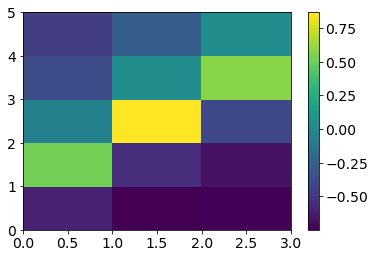

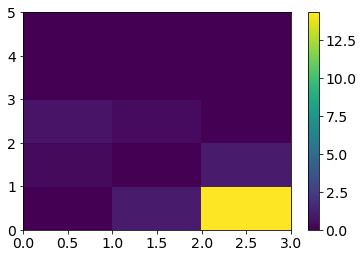

In [52]:
plt.pcolor(maxima)
plt.colorbar()
plt.show()

plt.pcolor(wsbs)
plt.colorbar()
plt.show()